In [1]:
import pymc3 as pm
import theano.tensor as tt

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl


In [2]:
import numpy as np

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from pymc3 import Metropolis

### Choosing the priors for GP hyper-parameters is crucial for convergence and identifiability. 
Starting with a reasonable length scale prevents curves that wiggle too much, which would make Bayesian linear regression unstable. The scale of GPs needs an informative prior because the regression coeffcients could be scaled by some constant. As a note, the Metropolis proposal distribution is standard Normal so the length scale is set up to be in a similar range.

In [5]:
from scipy.stats import cauchy

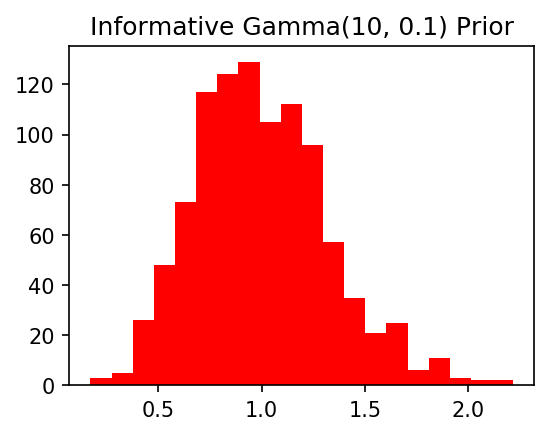

In [6]:
fig = plt.figure(figsize=(4, 3), dpi=150)
x = np.random.gamma(10, 0.1, 1000)
plt.hist(x, bins=20, color='red')
plt.title('Informative Gamma(10, 0.1) Prior')
plt.show()

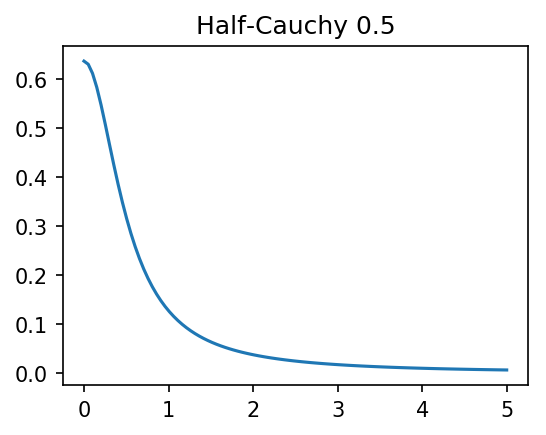

In [7]:
fig = plt.figure(figsize=(4, 3), dpi=150)
x = np.linspace(0, 5, 100)
y = cauchy.pdf(x, loc=0, scale=0.5)
plt.plot(x, y)
plt.title('Half-Cauchy 0.5')
plt.show()

In [8]:
def sample_gp_posterior(F_column, n_sample=100, gprior_params=(10, 0.1),  prior_scale=0.5, sigma=1e-3, test=False):
    """
    Sample from GP posterior given one column of F (single factor).
    
    Args
        F_column: (numpy array) [t] latent observations at t time points
        n_sample: (int) MCMC chain length
        gprior_params: (tuple) Gamma prior on length scale (distance between adjacent time points is always 0.1)
        prior_scale: (float) half-Cauchy prior scale
        sigma: (float) Gaussian process noise (set to small number for noise free latent process)
        test: (bool) test mode returns the trace
    """
    t = F_column.shape[0]
    X = np.linspace(0.1, t * 0.1, t).reshape((t, 1))
    with pm.Model() as model:
        l = pm.Gamma('l', gprior_params[0], gprior_params[1])  # informative prior for length scale
        s = pm.HalfCauchy('s', prior_scale)  # recommended prior for scale parameter
        K = s ** 2 * pm.gp.cov.ExpQuad(1, l)  
        #K = s ** 2 * pm.gp.cov.Matern32(1, l)  # Matern (nu=1.5) kernel
        gp = pm.gp.Marginal(cov_func=K)
        y_ = gp.marginal_likelihood('y', X=X, y=F_column, noise=sigma)
        trace = pm.sample(n_sample, Metropolis())  # use Metropolis instead of NUTS for speed
        #trace = pm.sample(n_sample)
    l = trace['l'][-1]
    s = trace['s'][-1]
    cov = sample_covariance(X, l, s)
    #mu, cov = gp.predict(X, point=trace[-1])
    if test:
        return cov, trace
    else:
        return cov

In [9]:
def sample_covariance(X, l, s):
    t = X.shape[0]
    cov_sample = np.zeros((t, t))
    for i in range(t):
        for j in range(t):
            cov_sample[i, j] = s ** 2 * np.exp(-(i * 0.1 - j * 0.1) ** 2 / (2 * l ** 2))
    return cov_sample

In [10]:
def sample_covariance_matern(X, l, s):
    t = X.shape[0]
    cov_sample = np.zeros((t, t))
    for i in range(t):
        for j in range(t):
            cov_sample[i, j] = s ** 2 * matern32(i * 0.1 - j * 0.1, l)
    return cov_sample

In [11]:
def matern32(d, l):
    return (1. + np.sqrt(3. * d ** 2) / l) * np.exp(-np.sqrt(3. * d ** 2) / l)

In [12]:
def blr(y, F, mu_0, Sigma_0, a_0, b_0, n_draws=1):
    n = y.shape[0]
    p = mu_0.shape[0]
    mu_post = np.matmul(np.linalg.inv(np.matmul(np.transpose(F), F) + Sigma_0),
                        np.matmul(Sigma_0, mu_0) + np.matmul(np.transpose(F), y))
    Sigma_post = np.matmul(np.transpose(F), F) + Sigma_0
    a_post = a_0 + n / 2
    b_post = b_0 + 0.5 * (np.matmul(np.transpose(y), y) + 
                          np.matmul(np.matmul(np.transpose(mu_0), Sigma_0), mu_0) - 
                          np.matmul(np.matmul(np.transpose(mu_post), Sigma_post), mu_post))
    beta = np.empty([n_draws, p])
    sigma2_eps = 1 / np.random.gamma(a_post, 1 / b_post, n_draws)
    
    for i in range(n_draws):
        beta[i, :] = np.random.multivariate_normal(mu_post, sigma2_eps[i] * np.linalg.inv(Sigma_post))
    return beta, sigma2_eps

In [13]:
def blr_mv(y, F, mu_0, Sigma_0, a_0, b_0):
    q = y.shape[1]
    r = F.shape[1]
    beta_est = np.empty([r, q])
    sigma2_eps_est = np.empty(q)
    for j in range(q):
        results = blr(y[:, j], F, mu_0, Sigma_0, a_0, b_0)
        beta_est[:, j] = results[0]
        sigma2_eps_est[j] = results[1]
    return beta_est, sigma2_eps_est

In [14]:
def build_covariance_blocks(F_covariance_list, loading_matrix, Y_variance):
    """
    Build covariance matrix for long vector of all columns of Y stacked together.
    
    Args
        F_covariance_list: (list) of [t, t] covariance matrices
        loading_matrix: (numpy array) [r, q] linear transformation between F and Y
        Y_sigma_list: (numpy array) [q] variance parameters for columns of Y
    """
    r = len(F_covariance_list)
    t = F_covariance_list[0].shape[0]
    q = loading_matrix.shape[1]
    block_YY = np.zeros((q * t, q * t))
    # covariance for columns of F
    block_FF_rows = []
    for i in range(r):
        current_row = np.zeros((t, r * t))
        current_row[:, (i * t):(i * t + t)] = F_covariance_list[i]
        block_FF_rows.append(current_row)
    block_FF = np.vstack(block_FF_rows)
    # covariance between columns of F and columns of Y
    block_FY_rows = []
    for i in range(r):
        current_row = np.zeros((t, q * t))
        for j in range(q):
            current_row[:, (j * t):(j * t + t)] = loading_matrix[i, j] * F_covariance_list[i]
        block_FY_rows.append(current_row)
    block_FY = np.vstack(block_FY_rows)
    block_YF = np.transpose(block_FY)
    # covariance between columns of Y
    block_YY_rows = []
    for i in range(q):
        current_row = np.zeros((t, q * t))
        for j in range(q):
            for k in range(r):
                current_row[:, (j * t):(j * t + t)] += F_covariance_list[k] * loading_matrix[k, i] * loading_matrix[k, j]
            if i == j:
                current_row[:, (j * t):(j * t + t)] += np.eye(t) * Y_variance[i]  # diagonal variance
        block_YY_rows.append(current_row)
    block_YY = np.vstack(block_YY_rows)
    return block_FF, block_FY, block_YF, block_YY

In [15]:
def sample_conditional_F(Y, block_FF, block_FY, block_YF, block_YY, debug=False):
    """
    Sample from conditional distribution of F given everything else.
    
    Args
        Y: (numpy array) [t, q] observed multivariate time series
        block_FF, block_FY, block_YF, block_YY: (numpy array) blocks in the covariance of joint distribution
    """
    t, q = Y.shape
    r = int(block_FF.shape[0] / t)
    Y_stack = np.transpose(Y).reshape(t * q)  # stack columns of Y
    block_YY_inverse = np.linalg.inv(block_YY)
    prod = np.matmul(block_FY, block_YY_inverse)
    mu = np.matmul(prod, Y_stack)
    covariance = block_FF - np.matmul(prod, block_YF)
    F_stack = np.random.multivariate_normal(mu, covariance)
    F_sample = np.transpose(F_stack.reshape((r, t)))  # de-stack columns of F
    if debug:
        return F_sample, covariance
    else:
        return F_sample

In [16]:
from scipy.io import loadmat
from scipy.linalg import expm, logm

In [17]:
data_odor = loadmat('/Users/linggeli/neuroscience/data/SuperChris/super_chris_extraction_odor2s.mat')

In [18]:
trial_info = data_odor['trialInfo']
select_odor_A = (trial_info[:, 0] == 1) & (trial_info[:, 1] == 1) & (trial_info[:, 3] == 1)
lfp_odor_A = data_odor['lfpEpoch'][select_odor_A, 2000:4000, :]
lfp_data = lfp_odor_A[0, :, 5:8]
print(lfp_data.shape)

(2000, 3)


In [19]:
cov_series = np.zeros((100, 3, 3))  # time series of covariance matrices
utv_series = np.zeros((100, 6))  # time series of upper triangular vector
for t in range(100):
    lfp_window = lfp_data[(t * 10):(t * 10 + 50), :]
    cov = np.cov(lfp_window, rowvar=False)
    cov_series[t, :, :] = cov
    utv = logm(cov)[np.triu_indices(3)]
    utv_series[t, :] = utv

In [20]:
# For training Gaussian processes, de-mean the data is important as it turns out
Y = utv_series - np.mean(utv_series, axis=0)
print(Y.shape)

(100, 6)


In [21]:
print(np.mean((utv_series - np.mean(utv_series, axis=0)) ** 2))

0.34410398582753127


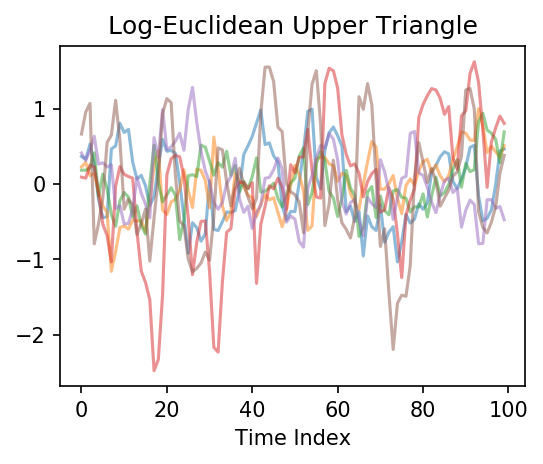

In [22]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(6):
    plt.plot(Y[:, j], alpha=0.5)
plt.title('Log-Euclidean Upper Triangle')
plt.xlabel('Time Index')
plt.show()

In [23]:
from sklearn.decomposition import PCA

In [24]:
latent_dim = 2
pca = PCA(n_components=latent_dim)
components = pca.fit_transform(Y)

In [25]:
Y_hat = pca.inverse_transform(components)
mse = np.mean((Y - Y_hat) ** 2)
print(mse)

0.09555769765025585


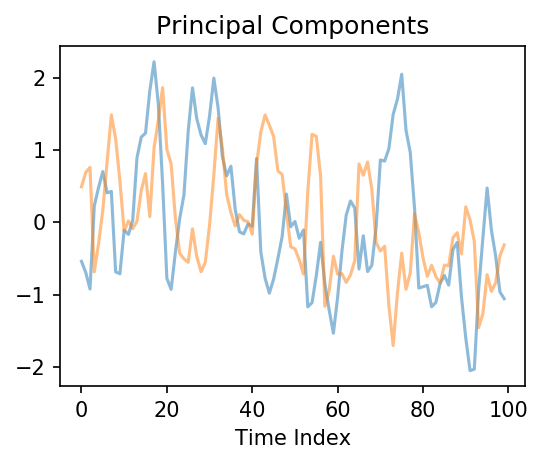

In [26]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(2):
    plt.plot(components[:, j], alpha=0.5)
plt.title('Principal Components')
plt.xlabel('Time Index')
plt.show()

### Check Bayesian linear regression with principal components

In [27]:
F = components

In [28]:
from sklearn import linear_model

In [29]:
Y_hat = np.zeros((100, 6))
for j in range(6):
    lm = linear_model.LinearRegression(fit_intercept=False)
    lm.fit(F, Y[:, j])
    y_pred = lm.predict(F)
    Y_hat[:, j] = y_pred
mse = np.mean((Y - Y_hat) ** 2)
print(mse)

0.09555769765025585


In [30]:
mu_0 = np.repeat(0, 2)  # prior mean 0 for regression coefficients
Sigma_0 = np.diag(np.repeat(1, 2))  # prior variance 1
a_0 = 1  # Inverse-Gamma(1, 1) is fairly diffused
b_0 = 1

In [31]:
loading_matrix, Y_variance = blr_mv(Y, F, mu_0, Sigma_0, a_0, b_0)
Y_hat = np.matmul(F, loading_matrix)
mse = np.mean((Y - Y_hat) ** 2)
print(mse)

0.09718031866101308


In [32]:
print(loading_matrix)
print(Y_variance)

[[-0.28633823 -0.06652133 -0.00139397 -0.74296049  0.14514403 -0.53054675]
 [ 0.15507488 -0.20331116 -0.04107421 -0.57334918  0.12781403  0.71195504]]
[0.14075927 0.12297734 0.1506161  0.03530735 0.20916166 0.05876689]


### Now sample from the GP prior (not the predictive distribution)

In [33]:
X = np.linspace(0.1, 100 * 0.1, 100).reshape((100, 1))  # create initial GP covariance matrices
cov1 = sample_covariance_matern(X, 1.0, 1.0)  # length scale 1.0 corresponds to 10 time points
cov2 = sample_covariance_matern(X, 1.0, 1.0)  # variance scale set to 1.0 as well

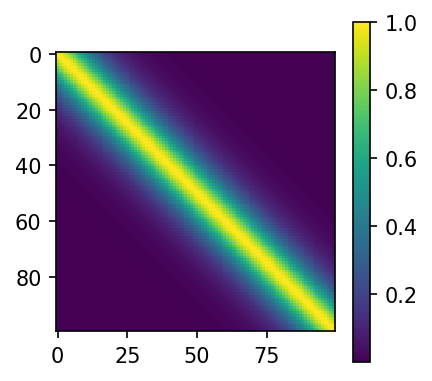

In [34]:
fig = plt.figure(figsize=(3, 3), dpi=150)
plt.imshow(cov1)
plt.colorbar()
plt.show()

In [35]:
S1, S2, S3, S4 = build_covariance_blocks([cov1, cov2], loading_matrix, Y_variance)

In [36]:
F_new, cov_new = sample_conditional_F(Y, S1, S2, S3, S4, debug=True)

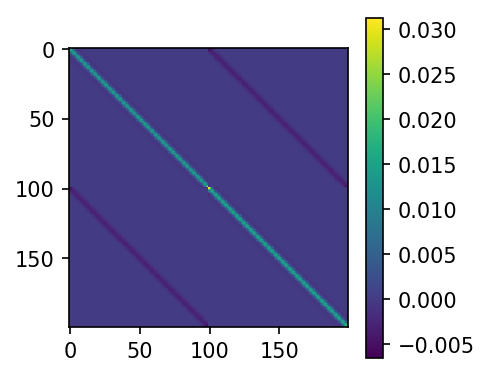

In [37]:
fig = plt.figure(figsize=(3, 3), dpi=150)
plt.imshow(cov_new)  # conditional covariance of F given Y
plt.colorbar()
plt.show()

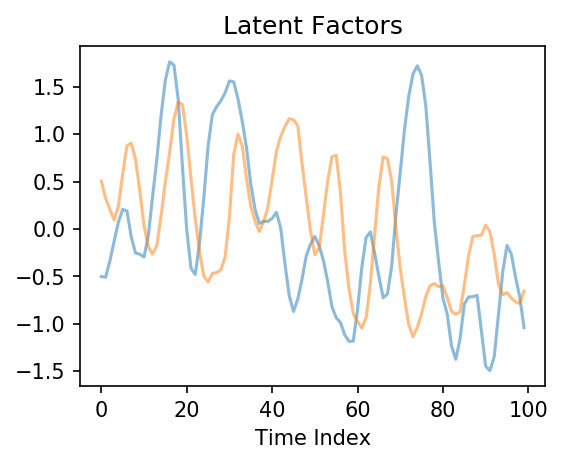

In [38]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(F_new[:, 0], alpha=0.5)
plt.plot(F_new[:, 1], alpha=0.5)
plt.title('Latent Factors')
plt.xlabel('Time Index')
plt.show()

In [39]:
F = F_new

In [40]:
gp1_trace_sample = []
gp2_trace_sample = []
loading_sample = []
variance_sample = []
F_sample = []

In [41]:
from tqdm import tqdm as tqdm

In [42]:
for i in tqdm(range(100)):
    # sample from Gaussian process
    cov1, trace1 = sample_gp_posterior(F[:, 0], test=True)
    cov2, trace2 = sample_gp_posterior(F[:, 1], test=True)
    # Bayesian linear regression
    loading_matrix, Y_variance = blr_mv(Y, F, mu_0, Sigma_0, a_0, b_0)
    Y_hat = np.matmul(F, loading_matrix)
    mse = np.mean((Y - Y_hat) ** 2)
    print(mse)
    # sample from conditional distribution of F
    S1, S2, S3, S4 = build_covariance_blocks([cov1, cov2], loading_matrix, Y_variance)
    F = sample_conditional_F(Y, S1, S2, S3, S4)
    # collect sample
    gp1_trace_sample.append(trace1)
    gp2_trace_sample.append(trace2)
    loading_sample.append(loading_matrix)
    variance_sample.append(Y_variance)
    F_sample.append(F)

  0%|          | 0/100 [00:00<?, ?it/s]//anaconda/envs/tensorflow/lib/python2.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is sm

0.13465548291969212


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
  2%|▏         | 2/100 [00:51<50:17, 30.79s/it]  

0.13469396831206876


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
  3%|▎         | 3/100 [01:03<40:48, 25.24s/it]

0.12914334256385948


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
  4%|▍         | 4/100 [01:17<34:47, 21.74s/it]

0.13674746011132147


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
  5%|▌         | 5/100 [01:29<30:02, 18.97s/it]

0.13090567686590865


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
  6%|▌         | 6/100 [01:42<26:38, 17.01s/it]

0.13527082354767278


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
  7%|▋         | 7/100 [01:54<24:11, 15.61s/it]

0.1368132451569405


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
  8%|▊         | 8/100 [02:07<22:41, 14.80s/it]

0.1306347205907647


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
  9%|▉         | 9/100 [02:19<21:19, 14.06s/it]

0.1329853663287215


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
 10%|█         | 10/100 [02:32<20:20, 13.56s/it]

0.13333839373312809


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
 11%|█         | 11/100 [02:44<19:36, 13.21s/it]

0.13487621064953342


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 12%|█▏        | 12/100 [02:57<18:56, 12.92s/it]

0.1296512687680448


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 13%|█▎        | 13/100 [03:09<18:23, 12.68s/it]

0.13076673701204314


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 14%|█▍        | 14/100 [03:21<18:06, 12.64s/it]

0.13241814644519365


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 15%|█▌        | 15/100 [03:33<17:42, 12.50s/it]

0.1352210443164584


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 16%|█▌        | 16/100 [03:46<17:33, 12.54s/it]

0.131322804762339


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 17%|█▋        | 17/100 [03:58<17:19, 12.53s/it]

0.14359279480615778


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 18%|█▊        | 18/100 [04:11<17:05, 12.51s/it]

0.13904063727357227


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
 19%|█▉        | 19/100 [04:23<16:50, 12.48s/it]

0.14048466741176513


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 20%|██        | 20/100 [04:36<16:37, 12.47s/it]

0.15663025143981632


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
 21%|██        | 21/100 [04:48<16:17, 12.37s/it]

0.1676061917886258


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 22%|██▏       | 22/100 [05:01<16:09, 12.43s/it]

0.1573985400765389


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
 23%|██▎       | 23/100 [05:13<15:57, 12.43s/it]

0.15495258459478034


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 24%|██▍       | 24/100 [05:26<15:50, 12.51s/it]

0.16163611078519274


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 25% for some parameters.
 25%|██▌       | 25/100 [05:38<15:33, 12.45s/it]

0.15108897811481248


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 26%|██▌       | 26/100 [05:50<15:14, 12.36s/it]

0.145177483629844


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 27%|██▋       | 27/100 [06:02<15:02, 12.37s/it]

0.13899851247491138


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
 28%|██▊       | 28/100 [06:15<14:55, 12.43s/it]

0.14719662732170127


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 29%|██▉       | 29/100 [06:28<14:48, 12.51s/it]

0.1402820661742178


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
 30%|███       | 30/100 [06:40<14:30, 12.43s/it]

0.1449198475504271


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 31%|███       | 31/100 [06:53<14:37, 12.72s/it]

0.15051517161359512


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 32%|███▏      | 32/100 [07:06<14:22, 12.68s/it]

0.16297774423852687


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 33%|███▎      | 33/100 [07:19<14:13, 12.74s/it]

0.16238869833472477


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 34%|███▍      | 34/100 [07:31<13:58, 12.70s/it]

0.15251482715605022


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 35%|███▌      | 35/100 [07:43<13:30, 12.47s/it]

0.1568841272902657


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 36%|███▌      | 36/100 [07:56<13:23, 12.55s/it]

0.16829931917431118


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
 37%|███▋      | 37/100 [08:09<13:13, 12.59s/it]

0.16224706226515218


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 38%|███▊      | 38/100 [08:22<13:04, 12.66s/it]

0.16236059410707018


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
 39%|███▉      | 39/100 [08:33<12:26, 12.24s/it]

0.1621265569537772


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
 40%|████      | 40/100 [08:46<12:21, 12.36s/it]

0.1557642594285887


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 41%|████      | 41/100 [08:58<12:14, 12.45s/it]

0.16098106549308763


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
 42%|████▏     | 42/100 [09:10<11:51, 12.27s/it]

0.15593052929934031


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 43%|████▎     | 43/100 [09:23<11:42, 12.33s/it]

0.15386078528248054


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 44%|████▍     | 44/100 [09:34<11:22, 12.19s/it]

0.15856847982535374


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 45%|████▌     | 45/100 [09:47<11:16, 12.30s/it]

0.15683606232676045


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 46%|████▌     | 46/100 [09:58<10:48, 12.01s/it]

0.16134175235151527


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
 47%|████▋     | 47/100 [10:11<10:46, 12.20s/it]

0.15196199085139023


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 48%|████▊     | 48/100 [10:23<10:31, 12.14s/it]

0.15192595910902354


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
 49%|████▉     | 49/100 [10:35<10:15, 12.06s/it]

0.1484251056039932


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 50%|█████     | 50/100 [10:48<10:13, 12.27s/it]

0.15128038367732016


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 51%|█████     | 51/100 [11:00<09:59, 12.24s/it]

0.15132987908029147


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 52%|█████▏    | 52/100 [11:12<09:54, 12.38s/it]

0.16032315795137342


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
 53%|█████▎    | 53/100 [11:25<09:37, 12.29s/it]

0.15184838612784668


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 54%|█████▍    | 54/100 [11:37<09:28, 12.36s/it]

0.1588231921761508


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 55%|█████▌    | 55/100 [11:50<09:17, 12.40s/it]

0.1644315804928588


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
 56%|█████▌    | 56/100 [12:02<09:11, 12.54s/it]

0.1697533787329699


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 57%|█████▋    | 57/100 [12:14<08:53, 12.40s/it]

0.16523294465405114


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 58%|█████▊    | 58/100 [12:27<08:37, 12.32s/it]

0.1618633968348811


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 59%|█████▉    | 59/100 [12:39<08:21, 12.23s/it]

0.15772122714786824


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 60%|██████    | 60/100 [12:51<08:06, 12.16s/it]

0.1646861936587312


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 61%|██████    | 61/100 [13:04<08:05, 12.45s/it]

0.16911847610432312


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 62%|██████▏   | 62/100 [13:16<07:49, 12.35s/it]

0.16348037990445277


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 63%|██████▎   | 63/100 [13:28<07:36, 12.33s/it]

0.16455023100793567


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
 64%|██████▍   | 64/100 [13:40<07:23, 12.32s/it]

0.17880941114697677


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
 65%|██████▌   | 65/100 [13:53<07:11, 12.34s/it]

0.1658803740792272


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 66%|██████▌   | 66/100 [14:05<06:58, 12.32s/it]

0.16675486572892959


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 67%|██████▋   | 67/100 [14:17<06:45, 12.29s/it]

0.16325732368873527


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 68%|██████▊   | 68/100 [14:29<06:31, 12.24s/it]

0.17396500191939235


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 69%|██████▉   | 69/100 [14:41<06:17, 12.18s/it]

0.16601845015377656


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 70%|███████   | 70/100 [14:54<06:04, 12.17s/it]

0.16294775931610947


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 71%|███████   | 71/100 [15:06<05:51, 12.11s/it]

0.1525534834786648


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 72%|███████▏  | 72/100 [15:18<05:39, 12.12s/it]

0.15820160683578177


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 73%|███████▎  | 73/100 [15:30<05:27, 12.13s/it]

0.15877980610659528


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
 74%|███████▍  | 74/100 [15:42<05:16, 12.17s/it]

0.15397852769309867


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
 75%|███████▌  | 75/100 [15:54<05:03, 12.15s/it]

0.15628146562510417


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
 76%|███████▌  | 76/100 [16:06<04:51, 12.13s/it]

0.1578360084026609


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
 77%|███████▋  | 77/100 [16:19<04:39, 12.16s/it]

0.15482372801346542


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 78%|███████▊  | 78/100 [16:31<04:27, 12.17s/it]

0.1469853584593293


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
 79%|███████▉  | 79/100 [16:43<04:15, 12.18s/it]

0.15023265707124872


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 80%|████████  | 80/100 [16:55<04:05, 12.26s/it]

0.15633479066728134


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 81%|████████  | 81/100 [17:08<03:53, 12.27s/it]

0.15709429042942777


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 82%|████████▏ | 82/100 [17:20<03:40, 12.26s/it]

0.15649388755761032


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
 83%|████████▎ | 83/100 [17:33<03:30, 12.37s/it]

0.14868763246191294


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
 84%|████████▍ | 84/100 [17:45<03:17, 12.34s/it]

0.15430937286295598


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 85%|████████▌ | 85/100 [17:56<02:58, 11.88s/it]

0.15232088914309566


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
 86%|████████▌ | 86/100 [18:08<02:47, 12.00s/it]

0.15617966804871522


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 25% for some parameters.
 87%|████████▋ | 87/100 [18:20<02:37, 12.15s/it]

0.15379221177764635


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
 88%|████████▊ | 88/100 [18:33<02:27, 12.25s/it]

0.16132394403337882


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 89%|████████▉ | 89/100 [18:45<02:15, 12.28s/it]

0.16711607948609017


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 90%|█████████ | 90/100 [18:59<02:06, 12.64s/it]

0.17145736833387806


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 91%|█████████ | 91/100 [19:25<02:30, 16.68s/it]

0.17275554103277221


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
 92%|█████████▏| 92/100 [19:43<02:17, 17.25s/it]

0.1678853543018902


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 93%|█████████▎| 93/100 [20:00<01:58, 16.93s/it]

0.16530109668858953


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
 94%|█████████▍| 94/100 [20:14<01:37, 16.31s/it]

0.16864850463249353


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
 95%|█████████▌| 95/100 [20:36<01:30, 18.02s/it]

0.17085672332877105


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
 96%|█████████▌| 96/100 [20:56<01:13, 18.35s/it]

0.15886471258758705


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
 97%|█████████▋| 97/100 [21:08<00:49, 16.52s/it]

0.15794354709144162


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
 98%|█████████▊| 98/100 [21:20<00:30, 15.32s/it]

0.1719826671684129


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
 99%|█████████▉| 99/100 [21:33<00:14, 14.53s/it]

0.17211691834966564


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 100/100 [21:46<00:00, 14.02s/it]

0.180216726094668


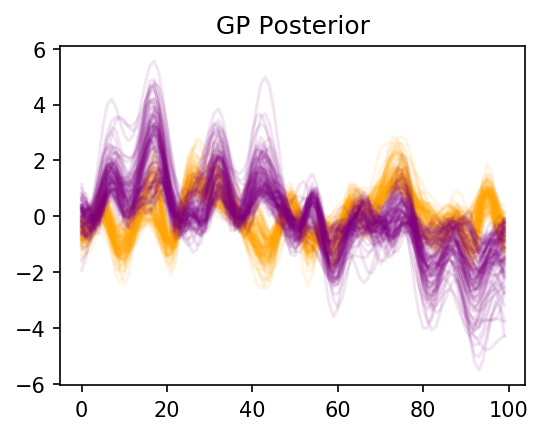

In [60]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(F_sample[i][:, 0], alpha=0.1, color='orange')
for i in range(100):
    plt.plot(F_sample[i][:, 1], alpha=0.1, color='purple')
plt.title('GP Posterior')
plt.show()

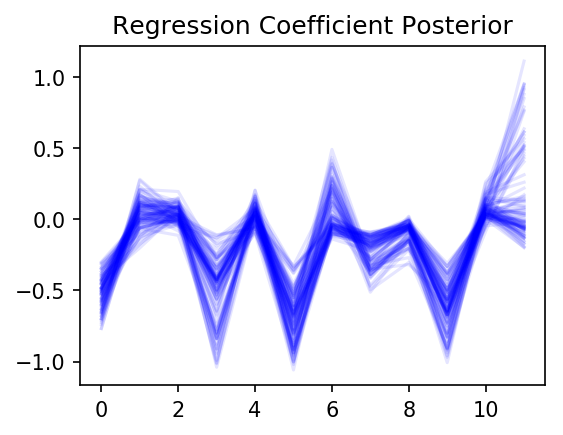

In [61]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(loading_sample[i].flatten(), alpha=0.1, color='blue')
plt.title('Regression Coefficient Posterior')
plt.show()

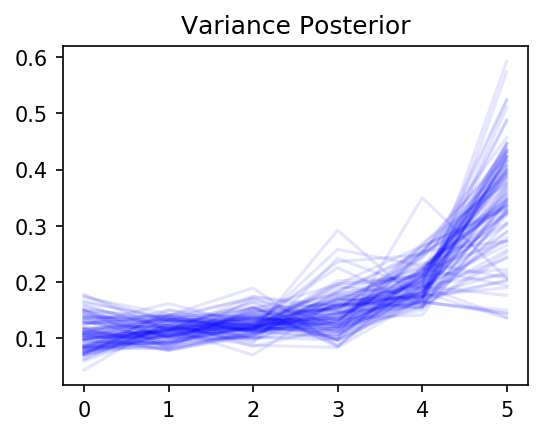

In [62]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(variance_sample[i], alpha=0.1, color='blue')
plt.title('Variance Posterior')
plt.show()

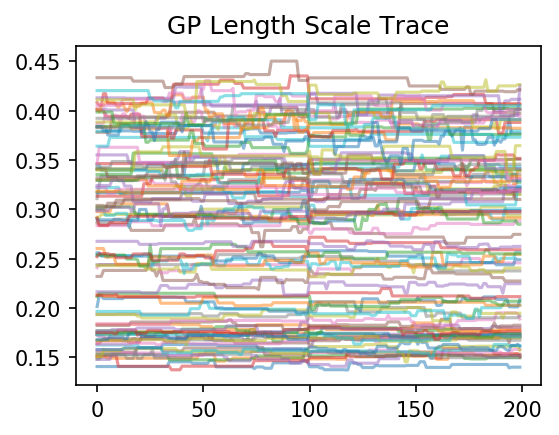

In [65]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(gp2_trace_sample[i]['l'], alpha=0.5)
plt.title('GP Length Scale Trace')
plt.show()

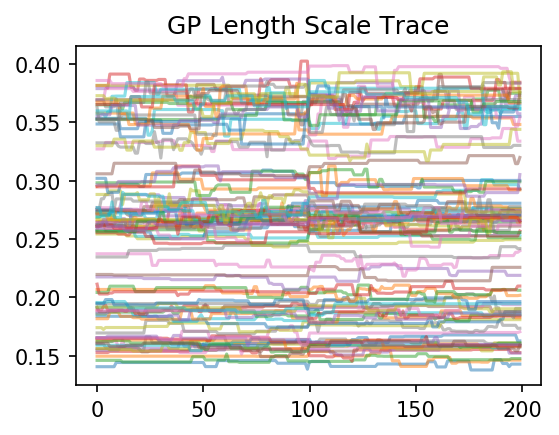

In [66]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(gp1_trace_sample[i]['l'], alpha=0.5)
plt.title('GP Length Scale Trace')
plt.show()

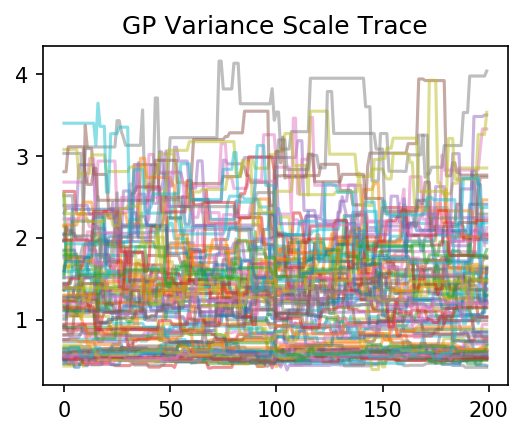

In [67]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(gp2_trace_sample[i]['s'], alpha=0.5)
plt.title('GP Variance Scale Trace')
plt.show()

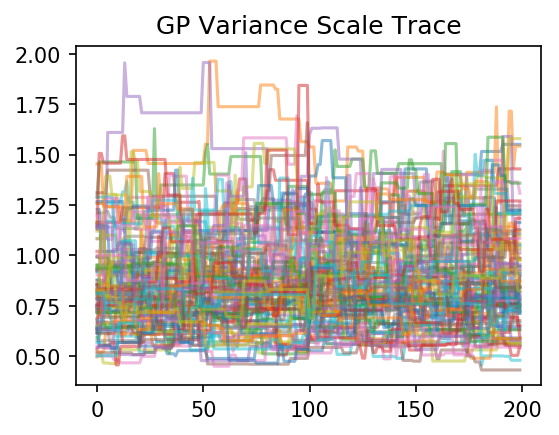

In [68]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(gp1_trace_sample[i]['s'], alpha=0.5)
plt.title('GP Variance Scale Trace')
plt.show()